# Xu-Net

## Libraries

In [1]:
import numpy
import numpy as np
import random
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from keras.layers import Activation
import tensorflow as tf
import cv2
from tensorflow.keras.layers import Lambda, Layer, ReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, SpatialDropout2D, Concatenate
tf.keras.layers.Concatenate()
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, BatchNormalization
from keras.layers.core import Reshape
from keras import optimizers
from tensorflow.keras import regularizers
from keras import Input, Model
from time import time
import time as tm
from keras.initializers import Constant, RandomNormal, glorot_normal
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
from keras import backend as K
from tensorflow.keras.utils import plot_model
from keras.layers import  concatenate

from tfkan.layers import DenseKAN
from tfkan.layers import Conv2DKAN
from tfkan.layers import base

## 30 SRM filters for preprocessing and the activation function

In [2]:
################################################## 30 SRM FILTERS
srm_weights = np.load('SRM_Kernels.npy') 
biasSRM=numpy.ones(30)
print (srm_weights.shape)
################################################## TLU ACTIVATION FUNCTION
T3 = 3;
def Tanh3(x):
    tanh3 = K.tanh(x)*T3
    return tanh3
##################################################

(5, 5, 1, 30)


## Functions

In [3]:
def squeeze_excitation_layer(input_layer, out_dim, ratio, conv):
  squeeze = tf.keras.layers.GlobalAveragePooling2D()(input_layer)
  excitation = tf.keras.layers.Dense(units=out_dim / ratio, activation='relu')(squeeze)
  excitation = tf.keras.layers.Dense(out_dim,activation='sigmoid')(excitation)
  excitation = tf.reshape(excitation, [-1,1,1,out_dim])
  scale = tf.keras.layers.multiply([input_layer, excitation])
  
  if conv:
    shortcut = tf.keras.layers.Conv2D(out_dim,kernel_size=1,strides=1,
                                      padding='same',kernel_initializer='he_normal')(input_layer)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)
  else:
    shortcut = input_layer
  out = tf.keras.layers.add([shortcut, scale])
  return out

## Xu-Net architecture

In [4]:
def Xu_Net( img_size=256, compile=True):
    
    #tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print ("using",2,"classes")
    
    inputs = tf.keras.Input(shape=(img_size,img_size,1), name="input")
    # Layer 1
    #conv0 =   tf.keras.layers.Conv2D(94, (5,5), weights=[filters,bias], strides=(1,1), trainable=False, activation=Tanh3, use_bias=True)(inputs)

    #Block 1
    layers_ty = tf.keras.layers.Conv2D(30, (5,5), weights=[srm_weights,biasSRM], strides=(1,1), trainable=False, padding='same', activation=Tanh3, use_bias=True)(inputs)
    layers_tn = tf.keras.layers.Conv2D(30, (5,5), weights=[srm_weights,biasSRM], strides=(1,1), trainable=True, padding='same', activation=Tanh3, use_bias=True)(inputs)
    layers1 = tf.keras.layers.add([layers_ty, layers_tn])

    
    layers = tf.keras.layers.Conv2D(30, (1,1), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers1) 
    layers = tf.keras.layers.ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
  
    layers = tf.keras.layers.Conv2D(30, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = tf.keras.layers.ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)

    layers = tf.keras.layers.Conv2D(30, (1,1), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = tf.keras.layers.ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    block_squeeze = squeeze_excitation_layer(layers, out_dim=30, ratio=32.0, conv=False)

    layers_Tr_1 = tf.keras.layers.add([layers1, block_squeeze])

    layers = tf.keras.layers.Conv2D(30, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers_Tr_1) 
    layers = tf.keras.layers.ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)

    layers = tf.keras.layers.Conv2D(30, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = tf.keras.layers.ReLU(negative_slope=0.1, threshold=0)(layers)
    layers3 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)

    layers_Tr_2 = tf.keras.layers.add([layers_Tr_1, layers3])

    layers = tf.keras.layers.Conv2D(30, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers_Tr_2) 
    layers = tf.keras.layers.ReLU(negative_slope=0.1, threshold=0)(layers)
    layers_n = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)

    layers = tf.keras.layers.Conv2D(30, (3,3), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers_n) 
    layers = tf.keras.layers.ReLU(negative_slope=0.1, threshold=0)(layers)
    layers4 = tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)

    #Block 1
    
    #Layer 0
    layers = Conv2D(8, (5,5), strides=(1,1),padding="same", kernel_initializer='glorot_normal', kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Concatenate()([layers, layers, layers])
    
    #Block 2
    
    #Layer 1
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(16, (5,5), strides=1,padding="same", kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=True, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)  
    layers = AveragePooling2D((5,5), strides= 2, padding='same')(layers)
    
    #Block 3
    
    #Layer 2
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(32, (1,1), strides=1,padding="same", kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = AveragePooling2D((5,5), strides= 2,padding="same")(layers)
    
    #Block 4
    #Layer 3
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(64, (1,1), strides=1,padding="same", kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers) 
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = AveragePooling2D((5,5), strides=2,padding="same")(layers)
    #Block 5
    #Layer 4
    layers = tf.keras.layers.SpatialDropout2D(rate=0.1)(layers)
    layers = Conv2D(128, (1,1), strides=1,padding="same", kernel_initializer='glorot_normal',kernel_regularizer=tf.keras.regularizers.l2(0.0001),bias_regularizer=tf.keras.regularizers.l2(0.0001))(layers)
    layers = ReLU(negative_slope=0.1, threshold=0)(layers)
    layers = tf.keras.layers.Lambda(tf.keras.backend.abs)(layers)
    layers = BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = Concatenate()([layers, layers, layers])
    layers = GlobalAveragePooling2D(data_format="channels_last")(layers)
    
    #Block 6
    #Layer 5, FC, Softmax
  
    #FC
    layers = DenseKAN(64)(layers)
    layers = DenseKAN(32)(layers)
    layers = DenseKAN(16)(layers)


    #Layer 18
    layers = DenseKAN(2)(layers)
    #Layer 19
    predictions = tf.keras.layers.Softmax(axis=1)(layers)
    model =tf.keras.Model(inputs = inputs, outputs=predictions)
    #Compile
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.95)
    
    if compile:
        model.compile(optimizer= optimizer,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        print ("Xunet")
    return model

## Defining different functions to work with the architecture

In [5]:

def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, initial_epoch = 0, model_name=""):
    start_time = tm.time()
    log_dir="D:/modelos/"+model_name+"_"+"{}".format(time())
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir)
    filepath = log_dir+"/saved-model.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath, 
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max',
        verbose=1
    )
    model.reset_states()
    history=model.fit(X_train, y_train, epochs=epochs, 
                        callbacks=[tensorboard,  checkpoint], 
                        batch_size=batch_size,
                        validation_data=(X_valid, y_valid),
                        initial_epoch=initial_epoch)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
    results_dir="D:/modelos//"+model_name+"/"
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
      
        plt.figure(figsize=(10, 10))
        #plt.subplot(1,2,1)
        #Plot training & validation accuracy values
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Accuracy Vs Epochs')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.grid('on')
        plt.savefig(results_dir+'Accuracy_Xu_Net_'+model_name+'.eps', format='eps')
        plt.savefig(results_dir+'Accuracy_Xu_Net_'+model_name+'.svg', format='svg')
        plt.savefig(results_dir+'Accuracy_Xu_Net_'+model_name+'.pdf', format='pdf')
        plt.show()
        
        plt.figure(figsize=(10, 10))
        #plt.subplot(1,2,2)
        #Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Loss Vs Epochs')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.grid('on')
        plt.savefig(results_dir+'Loss_Xu_Net_'+model_name+'.eps', format='eps')
        plt.savefig(results_dir+'Loss_Xu_Net_'+model_name+'.svg', format='svg')
        plt.savefig(results_dir+'Loss_Xu_Net_'+model_name+'.pdf', format='pdf')
        plt.show()

        '''
        plt.figure(figsize=(10, 10))
        #plt.subplot(1,2,2)
        #Plot training & validation loss values
        plt.plot(history.history['lr'])
        plt.ylabel('Lr')
        plt.xlabel('Epoch')
        plt.grid('on')
        plt.show()
        '''
    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [6]:
def Final_Results_Test(model,filename):

    if filename != ('train') and filename != ('validation'):
        print("\n\nBest")
        print(filename)
        model.load_weights(filename)
        loss,accuracy = model.evaluate(X_test, y_test,verbose=0)
        print(f'Loss={loss:.4f} y Accuracy={accuracy:0.4f}'+'\n') 


In [7]:
from tqdm import tqdm
def plot_train_valid(model,PATH_trained_models,model_name):
    acc_train=[]
    acc_valid=[]
    loss_train=[]
    loss_valid=[]
    for filename in tqdm(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model.load_weights(PATH_trained_models+'/'+filename)
            loss,accuracy = model.evaluate(X_train, y_train,verbose=0)
            acc_train.append(accuracy)
            loss_train.append(loss)
            loss,accuracy = model.evaluate(X_valid, y_valid,verbose=0)
            acc_valid.append(accuracy)
            loss_valid.append(loss)

    results_dir="D:/modelos/"+model_name+"/"
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)

   
        plt.figure(figsize=(10, 10))
        #plt.subplot(1,2,1)
        #Plot training & validation accuracy values
        plt.plot(acc_train)
        plt.plot(acc_valid)
        plt.title('Accuracy Vs Epochs')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.grid('on')
        plt.savefig(results_dir+'Accuracy_Xu_Net_'+model_name+'.eps', format='eps')
        plt.savefig(results_dir+'Accuracy_Xu_Net_'+model_name+'.svg', format='svg')
        plt.savefig(results_dir+'Accuracy_Xu_Net_'+model_name+'.pdf', format='pdf')
        plt.show()

        plt.figure(figsize=(10, 10))
        #plt.subplot(1,2,2)
        #Plot training & validation loss values
        plt.plot(loss_train)
        plt.plot(loss_valid)
        plt.title('Loss Vs Epochs')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.grid('on')
        plt.savefig(results_dir+'Loss_Xu_Net_'+model_name+'.eps', format='eps')
        plt.savefig(results_dir+'Loss_Xu_Net_'+model_name+'.svg', format='svg')
        plt.savefig(results_dir+'Loss_Xu_Net_'+model_name+'.pdf', format='pdf')
        plt.show()

        '''
        plt.figure(figsize=(10, 10))
        #plt.subplot(1,2,2)
        #Plot training & validation loss values
        plt.plot(history.history['lr'])
        plt.ylabel('Lr')
        plt.xlabel('Epoch')
        plt.grid('on')
        plt.show()
        '''
    results={'acc_train':acc_train,'acc_valid':acc_valid,'loss_train':loss_train,'loss_valid':loss_valid}
    return results

## Plot ROC curves

In [8]:
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)

def get_curve(gt, pred, target_names,model_name):
    labels=[]
    for i in range(len(target_names)):
        
        curve_function = roc_curve
        auc_roc = roc_auc_score(gt[:, i], pred[:, i])
        label = model_name+target_names[i] + " AUC: %.3f " % auc_roc
        labels.append(label)
        xlabel = "False positive rate"
        ylabel = "True positive rate"
        a, b, _ = curve_function(gt[:, i], pred[:, i])
        plt.figure(1, figsize=(7, 7))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(a, b, label=label)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

        plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1),
                  fancybox=True, ncol=1)
      
    return [a,b],labels
labels = ["Cover","Stego"]

## Working with BOSSbase 1.01 WOW y PAYLOAD = 0.4bpp

In the README, there is a link to download the databases we use for the work. There are two databases BOSSbase 1.01 and Bows2+ BOSSbase 1.01, cover images and stego. You can choose the payload of 0.2 and 0.4 bpp for each of the databases.

In [9]:
#Train
X_train = np.load('data_download\X_train.npy')
y_train = np.load('data_download\y_train.npy')
#Valid
X_valid = np.load('data_download\X_valid.npy')
y_valid = np.load('data_download\y_valid.npy')
#Test
X_test = np.load('data_download\X_test.npy')
y_test = np.load('data_download\y_test.npy')

X_train = np.transpose(X_train, (0, 2, 3, 1)) 
X_valid = np.transpose(X_valid, (0, 2, 3, 1))

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)


(8000, 256, 256, 1)
(8000, 2)
(2000, 256, 256, 1)
(2000, 2)
(10000, 256, 256, 1)
(10000, 2)


## CNN name and algorithm 

In [10]:
base_name="04S-UNIWARD"
m_name="XU_Net"

## Training

using 2 classes
Xunet
Epoch 1/400
250/250 [==============================] - ETA: 0s - loss: 0.7357 - accuracy: 0.4959
Epoch 1: val_accuracy improved from -inf to 0.50550, saving model to D:/modelos/Model_XU_Net_04S-UNIWARD_1728342103.1582682\saved-model.hdf5
250/250 [==============================] - 80s 295ms/step - loss: 0.7357 - accuracy: 0.4959 - val_loss: 0.7324 - val_accuracy: 0.5055
Epoch 2/400
250/250 [==============================] - ETA: 0s - loss: 0.7343 - accuracy: 0.4963
Epoch 2: val_accuracy did not improve from 0.50550
250/250 [==============================] - 71s 286ms/step - loss: 0.7343 - accuracy: 0.4963 - val_loss: 0.7341 - val_accuracy: 0.5015
Epoch 3/400
250/250 [==============================] - ETA: 0s - loss: 0.7325 - accuracy: 0.5060
Epoch 3: val_accuracy did not improve from 0.50550
250/250 [==============================] - 72s 287ms/step - loss: 0.7325 - accuracy: 0.5060 - val_loss: 0.7404 - val_accuracy: 0.5000
Epoch 4/400
250/250 [=====================

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


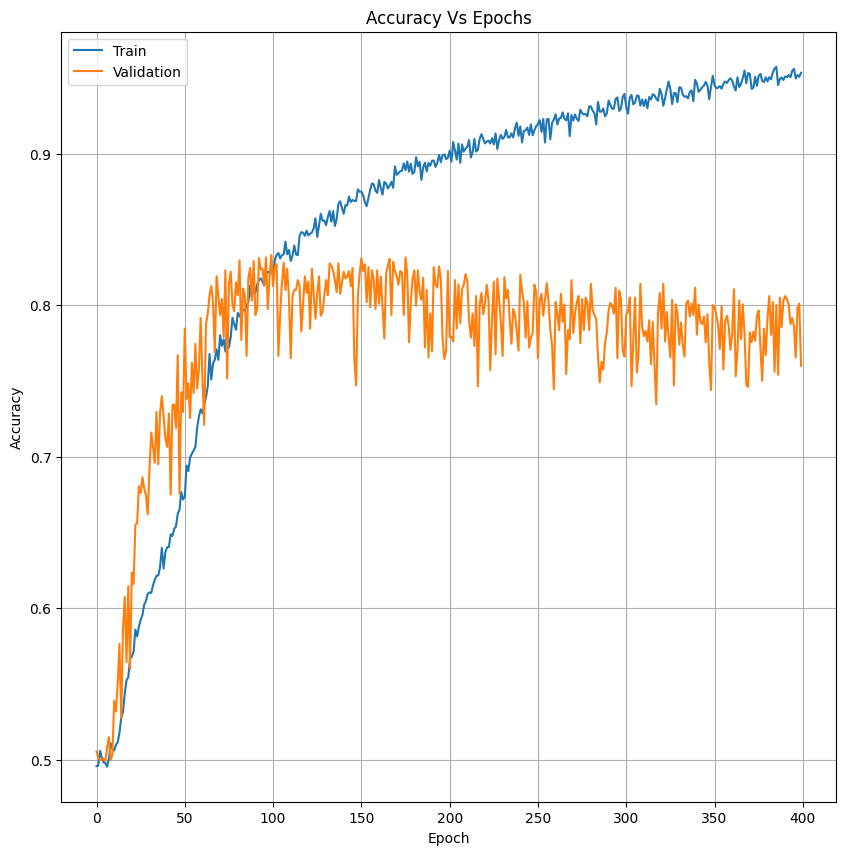

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


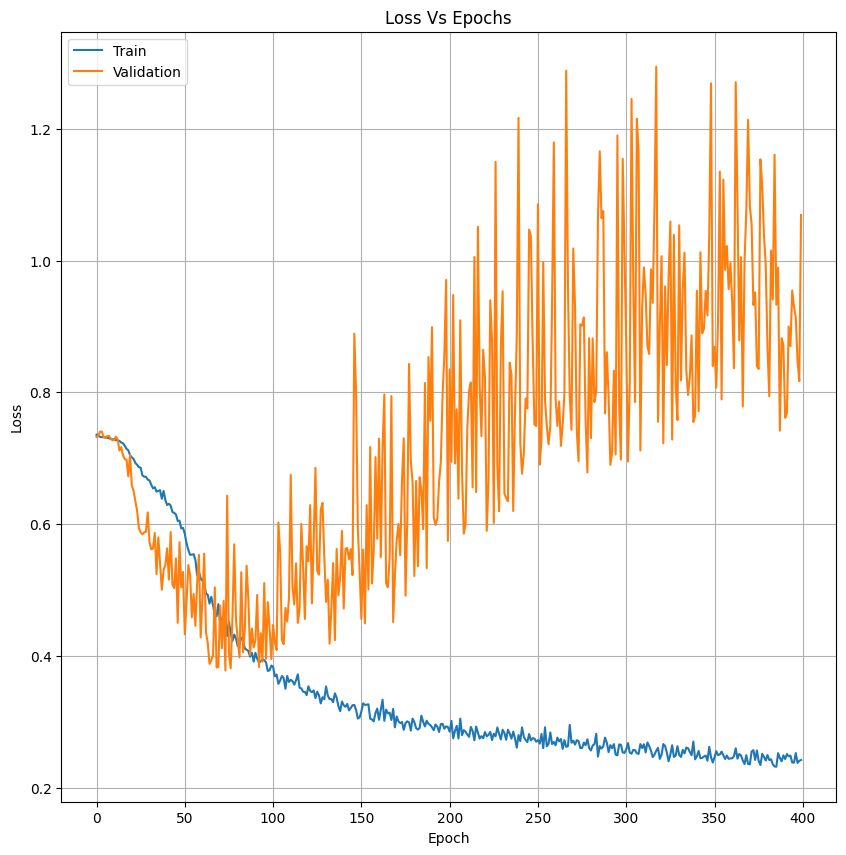

Time Model_XU_Net_04S-UNIWARD = 29294.99915456772 [seconds]


In [11]:
model= Xu_Net() 
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=32, epochs=400, model_name=name)

## Test

In [14]:
model= Xu_Net() 
PATH_trained_models = "D:\modelos\Model_XU_Net_04S-UNIWARD_1728342103.1582682\saved-model.hdf5"
Final_Results_Test(model,PATH_trained_models)

using 2 classes
Xunet


Best
D:\modelos\Model_XU_Net_04S-UNIWARD_1728342103.1582682\saved-model.hdf5
Loss=0.7837 y Accuracy=0.7031



## Training, validation and testing graph

In [ ]:
model= Xu_Net()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

## ROC curves

In [ ]:
model= Xu_Net() 
model.load_weights("") #path best model
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="Xu_Net WOW - "
curve1,labels1=get_curve(y_test, predictions, labels,model_name)

If you want to train the algorithm with another database, change "PATH04_WOW1" and  "base_name".

## Note

Note that when you train a model with a 0.2bpp payload, you need to transfer the best model at 0.4bpp. For example, if I need to train the CNN with WOW 0.2bpp, you need to transfer the weights of the best model trained on WOW 0.4bpp.

## Example train CNN with WOW 0.2bpp.

In [ ]:
base_name="02WOW1"
m_name="XU_Net"

### Training

In [ ]:
model= Xu_Net() 
model.load_weights("") #best Model 0.4
name="Model_"+m_name+"_"+base_name
_, history  = train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=64, epochs=50, model_name=name)

### Test

In [ ]:
model= Xu_Net() 
PATH_trained_models = " "
Final_Results_Test(model,PATH_trained_models)

### Training, validation and testing graph

In [ ]:
model=Xu_Net()  
PATH_trained_models = ""
name="Model_"+m_name+"_"+base_name
res=plot_train_valid(model,PATH_trained_models,name)

### ROC curves

In [ ]:
model= Xu_Net() 
model.load_weights("") #best Model train
predictions= model.predict(X_test,verbose=0)
labels = ["Cover","Stego"]
model_name="Xu-Net WOW - "
curve3_1,labels3_1=get_curve(y_test, predictions, labels,model_name)